In [66]:
import scipy.io as sio
import os
import pandas as pd
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [90]:
dataset_dir = "..\StanfordCarDataset"
# Load the data from the .mat file
data = sio.loadmat(f"{dataset_dir}\cars_annos.mat")
cars_meta = sio.loadmat(f"{dataset_dir}\cars_meta.mat")
cars_train_annos = sio.loadmat(f"{dataset_dir}\cars_train_annos.mat")
cars_test_annos = sio.loadmat(f"{dataset_dir}\cars_test_annos.mat")
print(cars_test_annos["annotations"][0][1])

(array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))


In [92]:
def transform_mat_to_csv(path=dataset_dir, csv_file_name="cars_annos.csv", data=data, parsing_fun=None):
    annotations = data['annotations'][0]
    csv_data, csv_columns = parsing_fun(annotations, data)
    df = pd.DataFrame(csv_data, columns=csv_columns)
    df.to_csv(f"{path}/{csv_file_name}", index=False)
    return df

def parse_cars_annos(annotations, data):
    csv_data = []
    class_names = [c[0] for c in data['class_names'][0]]
    for annotation in annotations:
        file_name = annotation[0][0]
        class_id = annotation[5][0][0] - 1
        class_name = class_names[class_id]
        x1 = annotation[1][0][0]
        y1 = annotation[2][0][0]
        x2 = annotation[3][0][0]
        y2 = annotation[4][0][0]
        csv_data.append([file_name, class_id, class_name, x1, y1, x2, y2])

    return csv_data, ["file_name", "class_id", "class_name", "x1", "y1", "x2", "y2"]

def parse_test_annos(annotations, data):
    csv_data = []
    for annotation in annotations:
        file_name = annotation[4][0]
        x1 = annotation[0][0][0]
        y1 = annotation[1][0][0]
        x2 = annotation[2][0][0]
        y2 = annotation[3][0][0]
        csv_data.append([file_name, x1, y1, x2, y2])

    return csv_data, ["file_name", "x1", "y1", "x2", "y2"]

def create_train_annos_csv_with_mapped_class_names(annos_df, path=dataset_dir, file_name="cars_test_annos"):
    train_data = sio.loadmat(f"{path}/cars_train_annos.mat")
    train_annotations = train_data['annotations'][0]

    class_mapping = {row['class_id']: row['class_name'] for _, row in annos_df.iterrows()}

    train_data = []
    for annotation in train_annotations:
        file_name = annotation[5][0]
        class_id = annotation[4][0][0] - 1
        class_name = class_mapping[class_id]
        x1 = annotation[0][0][0]
        y1 = annotation[1][0][0]
        x2 = annotation[2][0][0]
        y2 = annotation[3][0][0]
        train_data.append([file_name, class_id, class_name, x1, y1, x2, y2])

   
    train_data_df = pd.DataFrame(train_data, columns=['file_name', 'class_id', 'class_name', 'x1', 'y1', 'x2', 'y2'])
    train_data_df.to_csv(f"{path}/cars_train_annos.csv", index=False)

# def add_class_names_to_test_data(test_df, annos_df, test_csv_path):
#     class_name_map = dict(zip(annos_df['class_id'], annos_df['class_name']))
#     test_df['class_name'] = test_df['class_id'].apply(lambda x: class_name_map.get(x))
#     test_df['class_name'].fillna('Unknown', inplace=True)
#     test_df.to_csv(test_csv_path, index=False)

# if not os.path.exists('cars_annos.csv'):
annos_df = transform_mat_to_csv(parsing_fun=parse_cars_annos)
create_train_annos_csv_with_mapped_class_names(annos_df)
test_df = transform_mat_to_csv(csv_file_name="cars_test_annos.csv", data=cars_test_annos, parsing_fun=parse_test_annos)
# add_class_names_to_test_data(test_df, annos_df, f"{dataset_dir}/cars_test_annos.csv")



Audi TTS Coupe 2012


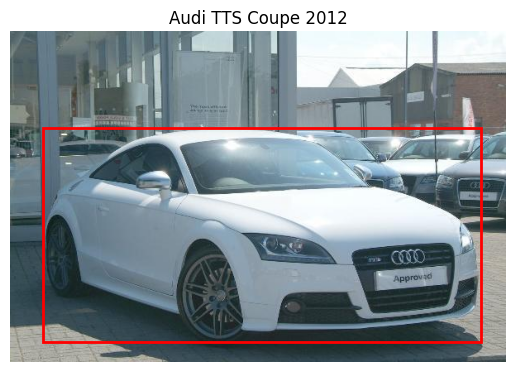

In [94]:

def get_assets(df, pos, is_train=True):
    folder = "cars_train/cars_train" if is_train else "cars_test/cars_test"
    folder = f"{dataset_dir}/{folder}"
    image = Image.open(f"{folder}/{df['file_name'][pos]}")
    title = df['class_name'][pos] if is_train else 'Unclassified'

    xy = df['x1'][pos], df['y1'][pos]
    width = df['x2'][pos] - df['x1'][pos]
    height = df['y2'][pos] - df['y1'][pos]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

def display_image(df, pos):
    image, title, rect = get_assets(df, pos)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

train_df = pd.read_csv(f"{dataset_dir}/cars_train_annos.csv")
display_image(train_df, 0)

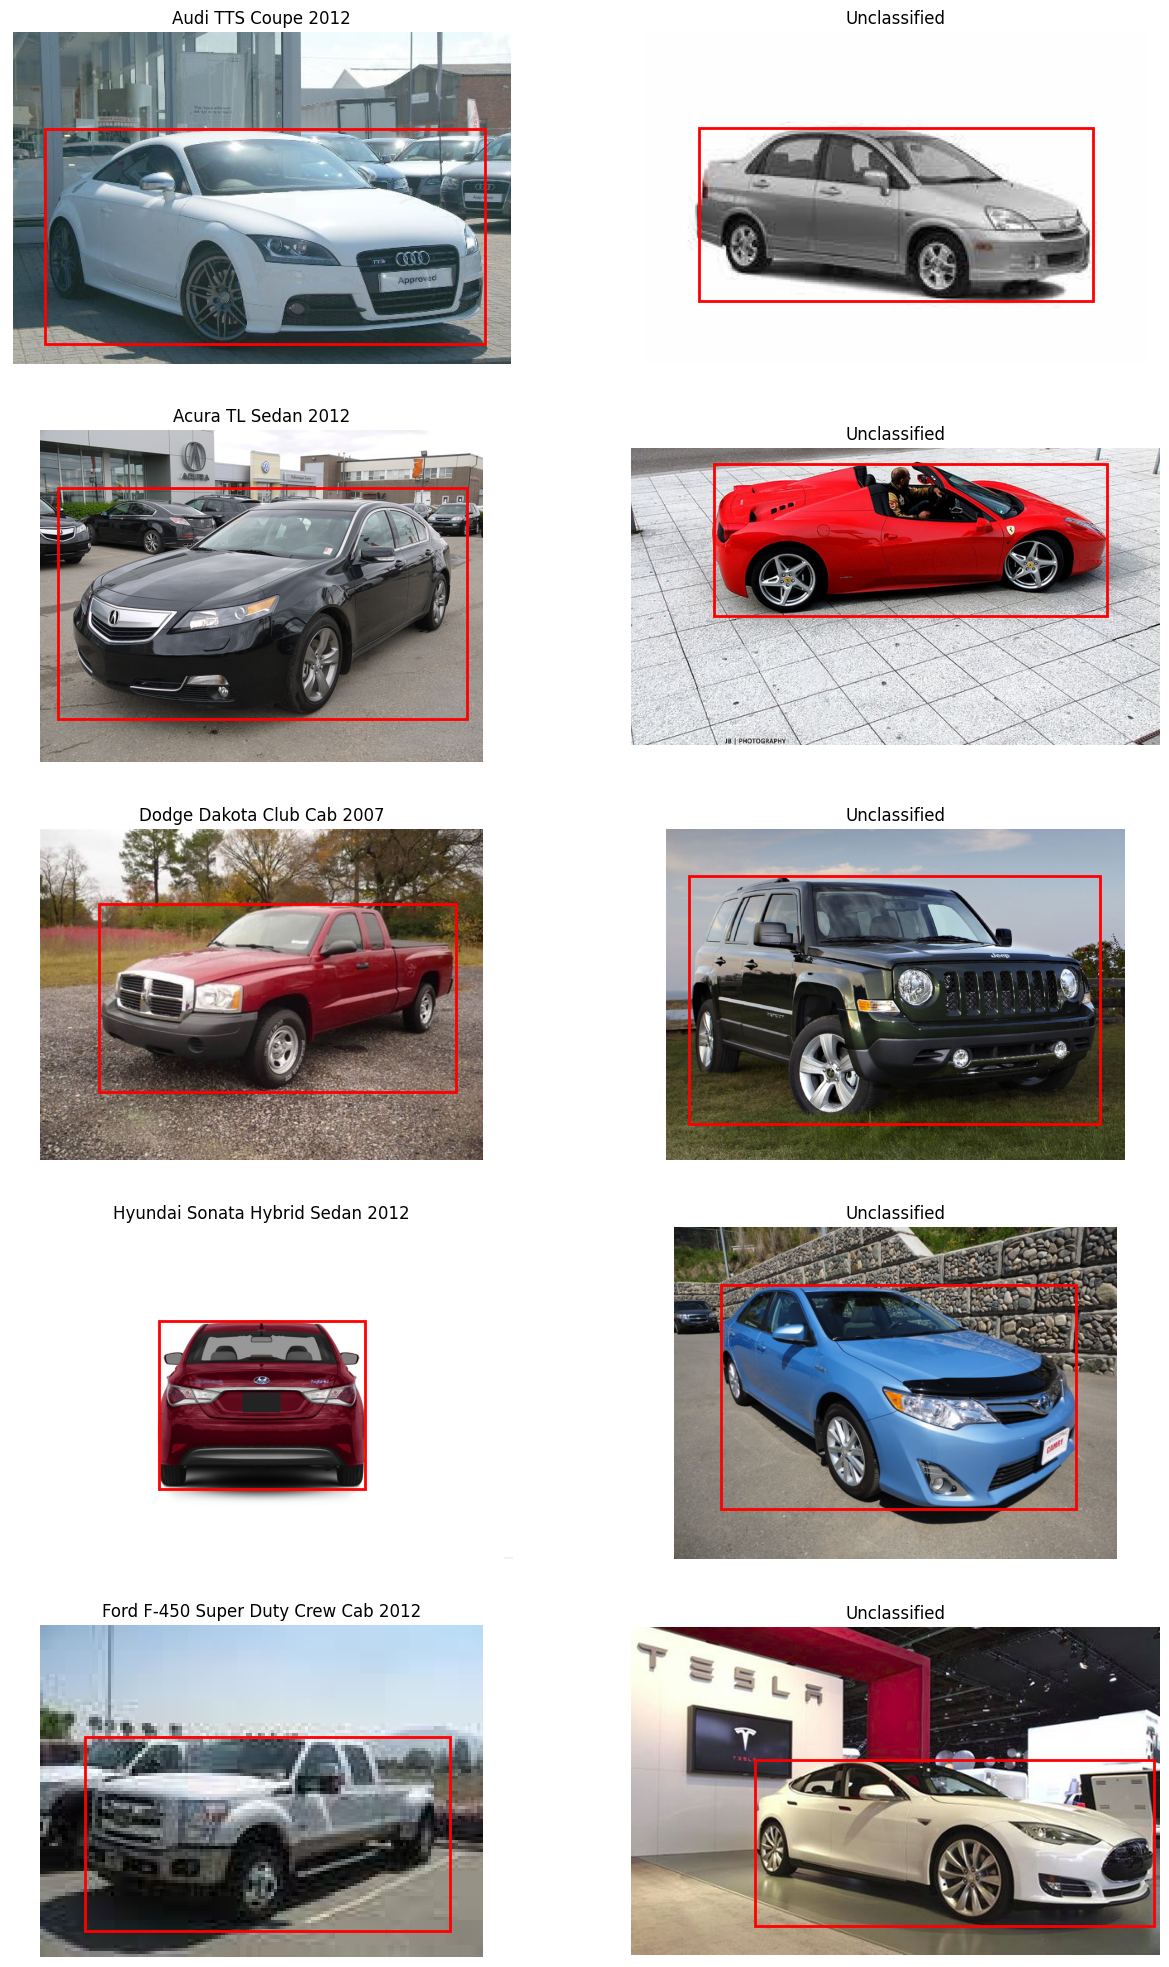

In [85]:
def display_range_train_test_img(train_df, test_df, end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(train_df, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(test_df, i, is_train=False)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
    plt.show()

test_df = pd.read_csv(f"{dataset_dir}/cars_test_annos.csv")
display_range_train_test_img(train_df=train_df, test_df=test_df, end=5, start = 0)

Cars Distribution:

In [87]:


freq_labels = train_df.groupby('class_name').count()[['class_id']]
freq_labels = freq_labels.rename(columns={'class_id': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()



,count
class_name,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


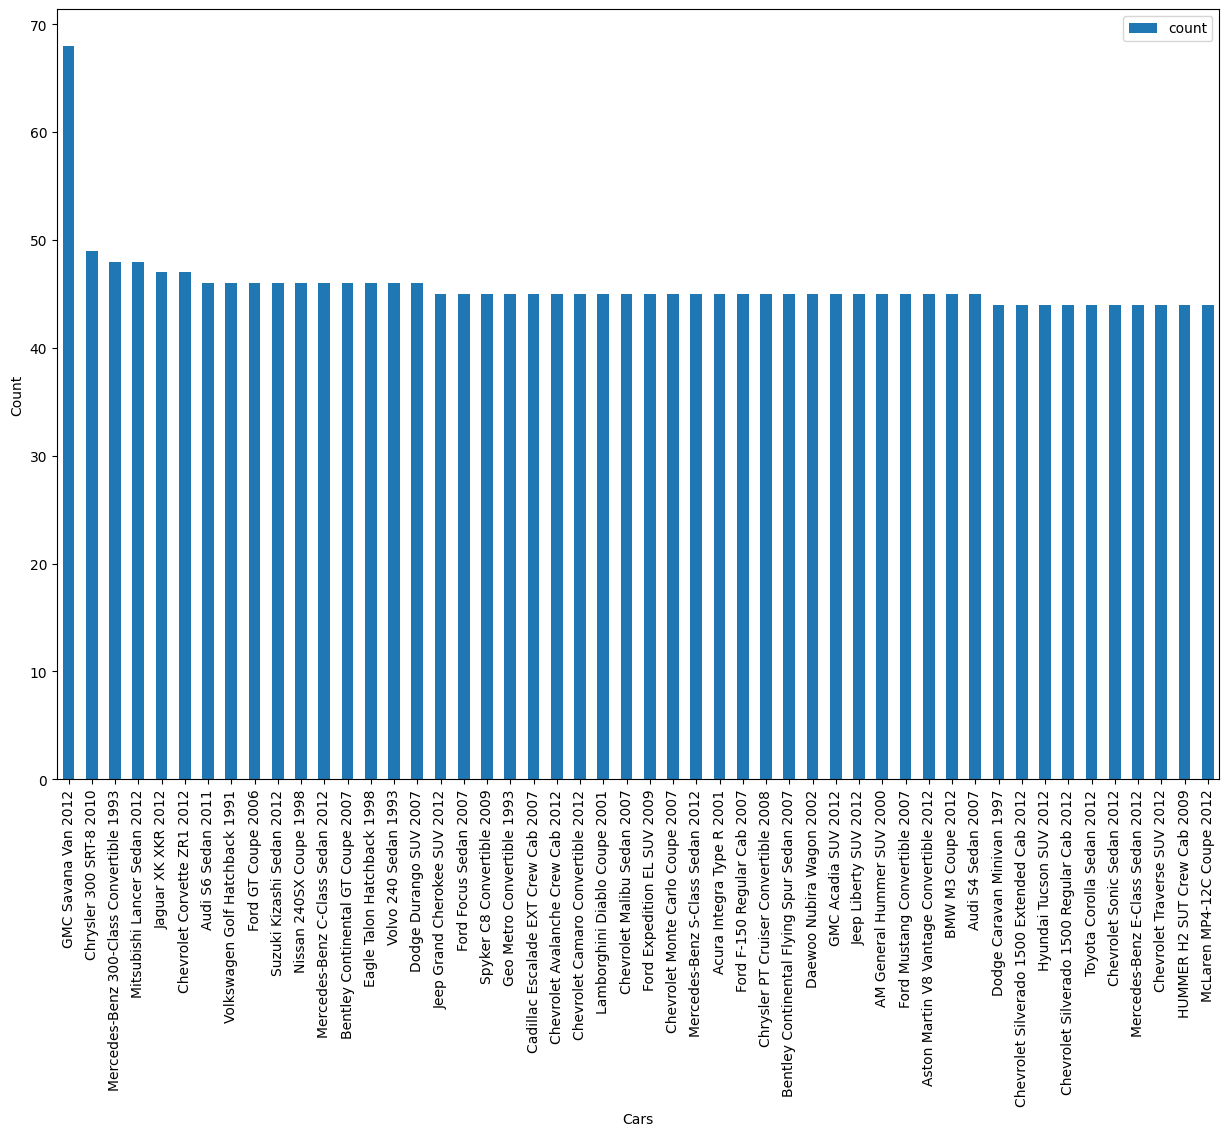

In [88]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");